In [47]:
import matplotlib.pyplot as plt
import numpy as np
import random
from cffi import FFI

from A_Star_Python import precompute_neighbors
from A_Star_Python import a_star_search as a_star_search_py

In [48]:
ffi = FFI()
ffi.cdef("""
int astar_search_path(const int *grid, int n, int start_x, int start_y, int end_x, int end_y, int **path_out, int *path_length);
void free(void *ptr);
""")

C = ffi.dlopen("./libastarsearchpath.so")

In [49]:
ffi2 = FFI()
ffi2.cdef("""
int astar_search(const int *grid, int n, int start_x, int start_y, int end_x, int end_y);
""")
C2 = ffi2.dlopen("./libastarsearch.so")

In [50]:
def astar_path_c(grid, start, end):
    n = grid.shape[0]
    grid_ptr = ffi.cast("int *", grid.ctypes.data)

    # Prepare pointers for path output and path length
    path_out_ptr = ffi.new("int **")
    path_length_ptr = ffi.new("int *")

    # Call the C function
    result = C.astar_search_path(grid_ptr, n, start[0], start[1], end[0], end[1], path_out_ptr, path_length_ptr)

    # Extract the path from the C data structure
    if result != -1 and path_length_ptr[0] > 0:
        path_length = path_length_ptr[0]
        path_array = np.frombuffer(ffi.buffer(path_out_ptr[0], path_length * 2 * ffi.sizeof("int")), dtype=np.int32)
        path = path_array.reshape(path_length, 2)
        # C.free(path_out_ptr[0])  # Corrected memory free call
        return path.tolist(), result
    else:
        return None, result

In [51]:
def astar_path_c2(grid, start, end):
    n = grid.shape[0]
    grid_ptr = ffi.cast("int *", grid.ctypes.data)

    # Call the C function
    length = C2.astar_search(grid_ptr, n, *start, *end)

    return length

In [52]:
def generate_grid():
    # Create a 400x400 array filled with zeros
    grid = np.zeros((400, 400), dtype=np.int32)
    
    # Randomly generate obstacles (1s)
    for _ in range(30000):  # Adjust the number of obstacles as needed
        x = random.randint(0, 399)
        y = random.randint(0, 399)
        grid[x, y] = 1
    
    # Generate start and goal positions
    start = (random.randint(0, 399), random.randint(0, 399))
    goal = (random.randint(0, 399), random.randint(0, 399))
    
    # Ensure start and goal positions are not obstacles
    while grid[start] == 1:
        start = (random.randint(0, 399), random.randint(0, 399))
    while grid[goal] == 1:
        goal = (random.randint(0, 399), random.randint(0, 399))
    
    return grid, start, goal


In [53]:
def generate_grid_20x20():
    # Create a 20x20 array filled with zeros
    grid = np.zeros((20, 20), dtype=np.int32)
    
    # Randomly generate obstacles (1s)
    for _ in range(30):  # Adjust the number of obstacles as needed
        x = random.randint(0, 19)
        y = random.randint(0, 19)
        grid[x, y] = 1
    
    # Generate start and goal positions
    start = (random.randint(0, 19), random.randint(0, 19))
    goal = (random.randint(0, 19), random.randint(0, 19))
    
    # Ensure start and goal positions are not obstacles
    while grid[start] == 1:
        start = (random.randint(0, 19), random.randint(0, 19))
    while grid[goal] == 1:
        goal = (random.randint(0, 19), random.randint(0, 19))
    
    return grid, start, goal

In [54]:
def plot_grid_with_path(grid, path):
    fig, ax = plt.subplots()
    ax.imshow(grid, cmap='binary')

    # Plot obstacles
    obstacles = np.where(grid == 1)
    ax.scatter(obstacles[1], obstacles[0], color='black', marker='s')

    # Plot path
    if path:
        path_x, path_y = zip(*path)
        ax.plot(path_y, path_x, marker='o', color='red')

    ax.set_xticks(np.arange(-0.5, grid.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, grid.shape[0], 1), minor=True)
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')

    plt.show()

In [55]:
grid, start, goal = generate_grid_20x20()
print(f"Start: {start}")
# goal = (start[0] + 8, start[1] + 6)
print(f"Goal: {goal}")

Start: (3, 3)
Goal: (6, 1)


In [56]:
print(f"grid: {grid}")

grid: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [57]:
# * the path for the Python implementation
grid_py = grid.tolist()
start_py = list(start)
goal_py = list(goal)
neighbors_dict = precompute_neighbors(grid_py)
path, actions = a_star_search_py(grid_py, start_py, goal_py, neighbors_dict)
print(f"=========")
print(f"Python implementation:")
print(f"Path length: {len(path)}")
print(f"path: {path}")

# * double check every coordinate in the path does not contain obstacles
for x, y in path:
    assert grid[x][y] == 0

Python implementation:
Path length: 6
path: [(3, 3), (4, 3), (4, 2), (4, 1), (5, 1), (6, 1)]


In [58]:
# * the path for the C implementation
path_c = astar_path_c(grid, start, goal)
print(f"=========")
print(f"C implementation:")
print(f"Path length: {len(path_c[0])}")
print(f"path: {path_c[0]}")

C implementation:
Path length: 6
path: [[3, 3], [4, 3], [5, 3], [6, 3], [6, 2], [6, 1]]


In [59]:
# * the path for the C implementation
length2 = astar_path_c2(grid, start, goal)
print(f"=========")
print(f"C2 implementation:")
print(f"Path length: {len(path_c[0])}")
print(f"path: {path_c[0]}")

C2 implementation:
Path length: 6
path: [[3, 3], [4, 3], [5, 3], [6, 3], [6, 2], [6, 1]]


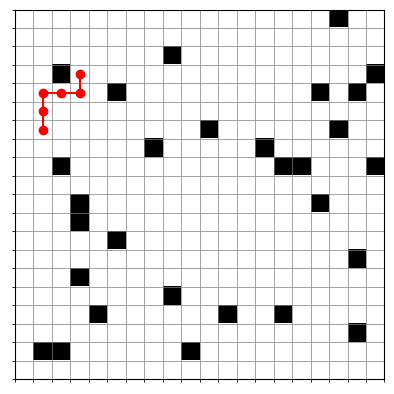

In [60]:
plot_grid_with_path(grid, path)

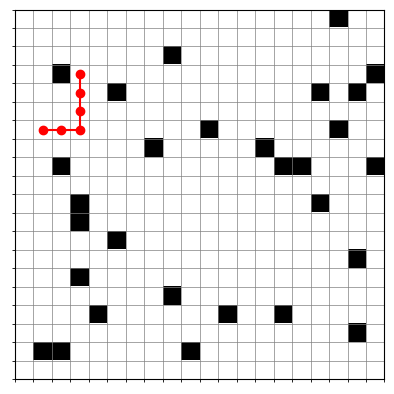

In [61]:
plot_grid_with_path(grid, path_c[0])